# Projeto de Probabilidade: Título a Decidir
por Gildo Augusto, Phelipe Henrique e Wanderson Alves

# 1 - Introdução

Neste Notebook, mostraremos a influência das faltas dos Alunos no seu desempenho acadêmico, referente ao período dos semestre de 2016.2, 2017.1 e 2017.2 em algumas disciplinas do Bacharelado em Tecnologia da Informação da UFRN (Universidade Federal do Rio Grande do Norte). Para essa representação utilizamos gráficos, através das bibliotecas Seaborn e Matplotlib da linguagem Pyhton 3, que torna possível uma melhor análise.

O Notebook está organizado da maneira a seguir: 
    - Seção 2: detalhes sobre o dataset que contém informações dos discentes. 
    - Seção 3: a representação dos gráficos que mostram a média do número de faltas de algumas disciplinas e a situação do aluno em questão (Aprovado, Aprovado por nota, Reprovado e Reprovados por média e por faltas). 
    - Seção 4: os gráficos que possui o número médio de faltas dos discentes nas disciplinas mostradas anteriormente dos 3 últimos semestres para a comparação dos mesmos.
    - Seção 5: a conclusão e apontametos obtidos através do estudo feito.

# 2 - Dataset Ensino
* As informações presentes no dataset são do Portal de Dados Abertos da UFRN (http://dados.ufrn.br/dataset/turmas).

In [334]:
# Boas práticas: criar uma célula com todas as bibliotecas necessárias
# importando as bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [336]:
# Turmas 2017.2
# http://dados.ufrn.br/dataset/turmas

# turmas
turmas_url_2017_2 = 'http://bit.do/turmas_ufrn_2017_2'

# matrículas em componentes em 2017.2
notas_url_2017_2 = 'http://bit.do/notas_ufrn_2017_2'

# turmas 2017.2
turmas_2017_2 = pd.read_csv(turmas_url, sep=';')

# matriculas em componentes em 2017.2
notas_2017_2 = pd.read_csv(notas_url, sep=';')

# componentes curriculares presenciais
disciplinas_url = 'http://bit.do/componentes_curriculares_ufrn'

# componentes curriculares presenciais
# por alguma razão ou outra, esse dataset tinha algum lixo em linhas que ocasionava 
# erros de leitura, dessa forma foi realizado um filtro apenas por colunas mais importantes
disciplinas = pd.read_csv(disciplinas_url, 
                          sep=';', 
                          usecols=["id_componente","codigo","nivel","nome","unidade_responsavel"])

In [337]:
# Turmas 2017.1

# turmas
turmas_url_2017_1 = 'http://bit.do/turmas_ufrn_2017_1'

# matrículas em componentes em 2017.1
notas_url_2017_1 = 'http://bit.do/notas_ufrn_2017_1'

# turmas 2017.1
turmas_2017_1 = pd.read_csv(turmas_url_2017_1, sep=';')

# matriculas em componentes em 2017.1
notas_2017_1 = pd.read_csv(notas_url_2017_1, sep=';')

In [338]:
# Turmas 2016.2

# turmas
turmas_url_2016_2 = 'http://bit.do/turmas_ufrn_2016_2'

# matrículas em componentes em 2016.2
notas_url_2016_2 = 'http://bit.do/notas_ufrn_2016_2'

# turmas 2016.2
turmas_2016_2 = pd.read_csv(turmas_url_2016_2, sep=';')

# matriculas em componentes em 2016.2
notas_2016_2 = pd.read_csv(notas_url_2016_2, sep=';')

In [340]:
# Adaptando o dataframe turma e disciplinas para o merge
# Esse procedimento é necessário pois o dataframe turma está codificado com ids

# A coluna id_componente precisa ser a mesma em ambos os dataframes
turmas_2017_2.rename(columns={'id_componente_curricular': 'id_componente'}, inplace=True)
turmas_2017_1.rename(columns={'id_componente_curricular': 'id_componente'}, inplace=True)
turmas_2016_2.rename(columns={'id_componente_curricular': 'id_componente'}, inplace=True)

# id_componente em ambos os dataframes precisam ser do mesmo tipo
turmas_2017_2.id_componente = turmas_2017_2.id_componente.astype(str)
turmas_2017_1.id_componente = turmas_2017_1.id_componente.astype(str)
turmas_2016_2.id_componente = turmas_2016_2.id_componente.astype(str)

# Limpando o dataframe disciplinas com linhas desnecessárias
disciplinas = disciplinas[~disciplinas.id_componente.duplicated()]

# Pegando apenas as disciplinas do IMD
disciplinas = disciplinas[disciplinas.unidade_responsavel == 'INSTITUTO METROPOLE DIGITAL']

In [341]:
# Fazendo um merge entre o dataframe turmas e disciplinas utilizando como base a coluna id_componente
# https://pandas.pydata.org/pandas-docs/stable/merging.html
colunas = ["id_turma","codigo","nivel_ensino","nome","unidade_responsavel",
          "situacao_turma","capacidade_aluno","descricao_horario", "ano", "periodo"]

# Merge os dois dataframes utilizando como base a coluna id_componente.
disciplinas_turma_2017_2 = pd.merge(turmas_2017_2, disciplinas, on='id_componente')[colunas]
disciplinas_turma_2017_1 = pd.merge(turmas_2017_1, disciplinas, on='id_componente')[colunas]
disciplinas_turma_2016_2 = pd.merge(turmas_2016_2, disciplinas, on='id_componente')[colunas]

In [343]:
colunas_relevantes = ["id_turma", "codigo", "nome", "descricao_horario", "ano", 
                      "periodo", "media_final", "numero_total_faltas", "descricao", "discente"]
# Merge de turma com as notas dos 3 semestres trabalhados.
notas_turma_turma_2017_2 = pd.merge(disciplinas_turma_2017_2, notas_2017_2, on='id_turma')[colunas_relevantes]
notas_turma_turma_2017_1 = pd.merge(disciplinas_turma_2017_1, notas_2017_1, on='id_turma')[colunas_relevantes]
notas_turma_turma_2016_2 = pd.merge(disciplinas_turma_2016_2, notas_2016_2, on='id_turma')[colunas_relevantes]

In [344]:
%%javascript
// Para evitar dos graficos ficarem contidos numa caixa com scroll.
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

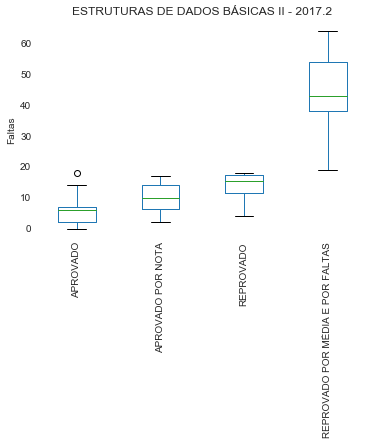

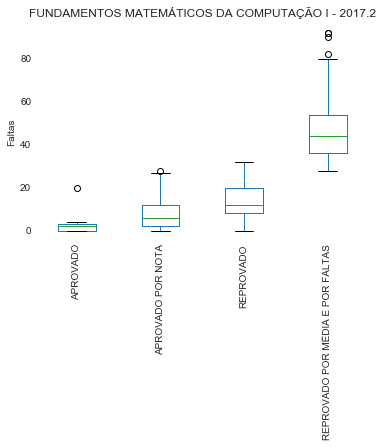

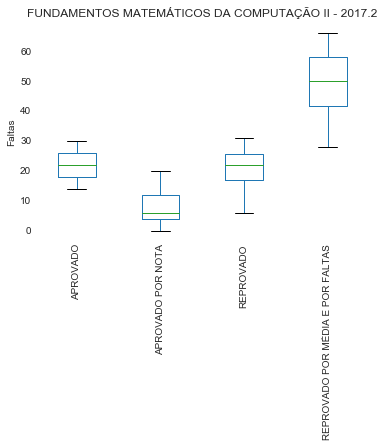

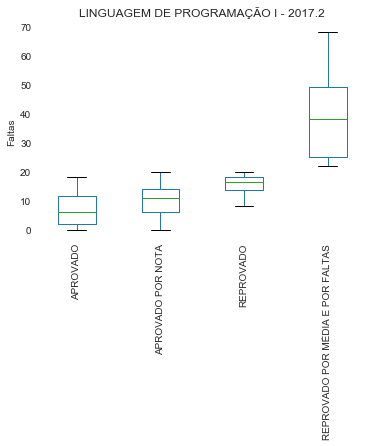

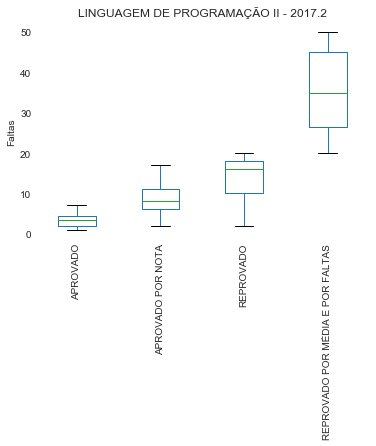

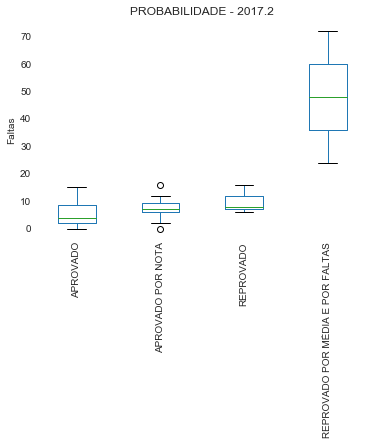

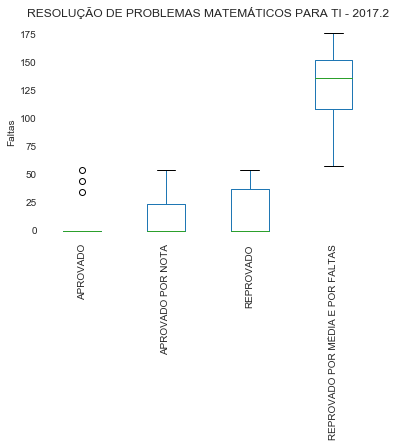

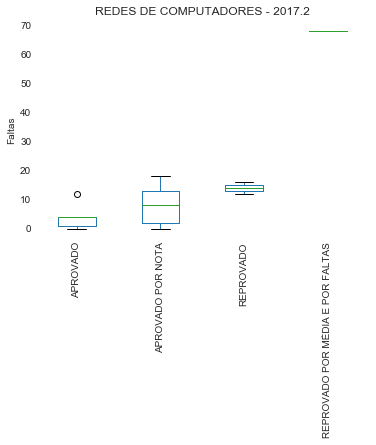

In [354]:
sns.set_style("whitegrid")

disciplinas = (
    'ESTRUTURAS DE DADOS BÁSICAS II',
    'FUNDAMENTOS MATEMÁTICOS DA COMPUTAÇÃO I',
    'FUNDAMENTOS MATEMÁTICOS DA COMPUTAÇÃO II',
    'LINGUAGEM DE PROGRAMAÇÃO I',
    'LINGUAGEM DE PROGRAMAÇÃO II',
    'PROBABILIDADE',
    'RESOLUÇÃO DE PROBLEMAS MATEMÁTICOS PARA TI',
    'REDES DE COMPUTADORES'
)
# Aqui é gerado um dicionário em que a chave é o nome da disciplina e o valor é um dataframe contendo as
# notas para aquela disciplina. Como a disciplina tem mais de uma unidade, a quantidade de faltas aparece em um
# numero igual a quantidade de unidades. Para evitar isso e gerar incosistências na análise foi removido esses
# dados duplicados e deixado apenas um por discente.
dataframes_notas_2017_2 = {}
for disciplina in disciplinas:
    dataframes_notas_2017_2[disciplina] = notas_turma_turma_2017_2[notas_turma_turma_2017_2.nome == disciplina].drop_duplicates('discente')
    
# Aqui percorremos o dataframes_notas_2017_2, montado anteriormente, e criamos o dataframe_grupos, que também tem como 
# chave o nome das disciplinas e um dataframe contendo os grupos de aprovaçoes como colunas.
dataframes_grupos_2017_2 = {}
for (disciplina, dataframe_2017_2) in dataframes_notas_2017_2.items():
    lista_status = list(filter(lambda i : i not in ('INDEFERIDO', 'TRANCADO', 'DESISTENCIA', 'EXCLUIDA', 'REPROVADO POR NOTA', 'CANCELADO'), dataframe_2017_2.descricao.unique()))
    dataframe_montado_2017_2 = {}
    for status in lista_status:
        dataframe_montado_2017_2[status] = dataframe_2017_2[dataframe_2017_2.descricao == status]['numero_total_faltas']
    dataframes_grupos_2017_2[disciplina] = pd.DataFrame.from_dict(dataframe_montado_2017_2)

# Aqui percorremos o dicionário de dataframes e criamos um gráfico para cada um.
for disciplina, dataframe_2017_2 in dataframes_grupos_2017_2.items():
    ax = dataframe_2017_2.plot(kind='box', rot=90, title=disciplina+' - 2017.2')
    ax.set(ylabel='Faltas')
    ax.grid(False)
    for key, spine in ax.spines.items():
        spine.set_visible(False)
        
# Concatenação para ser gerado um gráficos para um dataframe com a junção dos dataframes de todas as disciplinas trabalhadas
# do semestre de 2017.2
dataframe_todos_2017_2 = pd.concat(dataframes_grupos_2017_2.values())

In [300]:
# Aqui é gerado um dicionário em que a chave é o nome da disciplina e o valor é um dataframe contendo as
# notas para aquela disciplina. Como a disciplina tem mais de uma unidade, a quantidade de faltas aparece em um
# numero igual a quantidade de unidades. Para evitar isso e gerar incosistências na análise foi removido esses
# dados duplicados e deixado apenas um por discente.
dataframes_notas_2017_1 = {}
for disciplina in disciplinas:
    dataframes_notas_2017_1[disciplina] = notas_turma_turma_2017_1[notas_turma_turma_2017_1.nome == disciplina].drop_duplicates('discente')

# Aqui percorremos o dataframes_notas_2017_1, montado anteriormente, e criamos o dataframe_grupos, que também tem como 
# chave o nome das disciplinas e um dataframe contendo os grupos de aprovaçoes como colunas.
dataframes_grupos_2017_1 = {}
for (disciplina, dataframe_2017_1) in dataframes_notas_2017_1.items():
    lista_status = list(filter(lambda i : i not in ('INDEFERIDO', 'TRANCADO', 'DESISTENCIA', 'EXCLUIDA', 'REPROVADO POR NOTA', 'CANCELADO'), dataframe_2017_1.descricao.unique()))
    dataframe_montado_2017_1 = {}
    for status in lista_status:
        dataframe_montado_2017_1[status] = dataframe_2017_1[dataframe_2017_1.descricao == status]['numero_total_faltas']
    dataframes_grupos_2017_1[disciplina] = pd.DataFrame.from_dict(dataframe_montado_2017_1)
      
# Concatenação para ser gerado um gráficos para um dataframe com a junção dos dataframes de todas as disciplinas trabalhadas
# do semestre de 2017.1
dataframe_todos_2017_1 = pd.concat(dataframes_grupos_2017_1.values())

In [301]:
# Aqui é gerado um dicionário em que a chave é o nome da disciplina e o valor é um dataframe contendo as
# notas para aquela disciplina. Como a disciplina tem mais de uma unidade, a quantidade de faltas aparece em um
# numero igual a quantidade de unidades. Para evitar isso e gerar incosistências na análise foi removido esses
# dados duplicados e deixado apenas um por discente.
dataframes_notas_2016_2 = {}
for disciplina in disciplinas:
    dataframes_notas_2016_2[disciplina] = notas_turma_turma_2016_2[notas_turma_turma_2016_2.nome == disciplina].drop_duplicates('discente')

# Aqui percorremos o dataframes_notas_2016_2, montado anteriormente, e criamos o dataframe_grupos, que também tem como 
# chave o nome das disciplinas e um dataframe contendo os grupos de aprovaçoes como colunas.
dataframes_grupos_2016_2 = {}
for (disciplina, dataframe_2016_2) in dataframes_notas_2016_2.items():
    lista_status = list(filter(lambda i : i not in ('INDEFERIDO', 'TRANCADO', 'DESISTENCIA', 'EXCLUIDA', 'REPROVADO POR NOTA', 'CANCELADO'), dataframe_2016_2.descricao.unique()))
    dataframe_montado_2016_2 = {}
    for status in lista_status:
        dataframe_montado_2016_2[status] = dataframe_2016_2[dataframe_2016_2.descricao == status]['numero_total_faltas']
    dataframes_grupos_2016_2[disciplina] = pd.DataFrame.from_dict(dataframe_montado_2016_2)
    
# Concatenação para ser gerado um gráficos para um dataframe com a junção dos dataframes de todas as disciplinas trabalhadas
# do semestre de 2016.2
dataframe_todos_2016_2 = pd.concat(dataframes_grupos_2016_2.values())

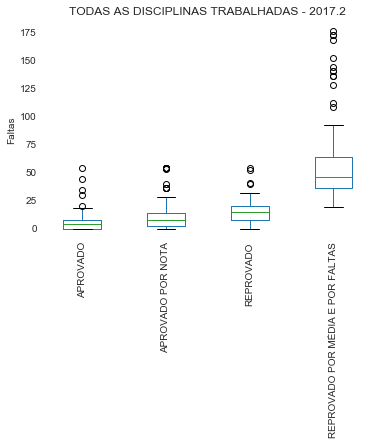

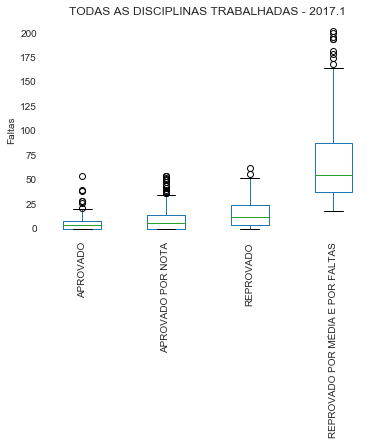

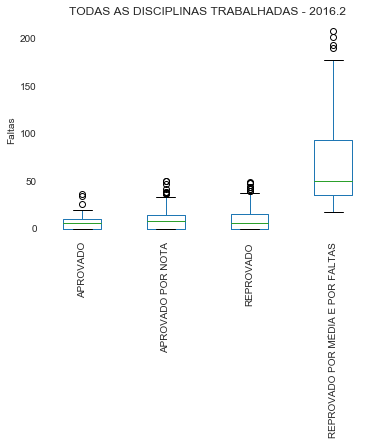

In [357]:
# Aqui é onde são gerados os gráficos de todas as disciplinas trabalhadas dos semestres 2016.2, 2017.1 e 2017.2.

ax_2017_2 = dataframe_todos.plot(kind='box', rot=90, title='TODAS AS DISCIPLINAS TRABALHADAS - 2017.2', grid = False)
ax_2017_2.set(ylabel='Faltas')
for key, spine in ax_2017_2.spines.items():
        spine.set_visible(False)
      
    
ax_2017_1 = dataframe_todos_2017_1.plot(kind='box', rot=90, title='TODAS AS DISCIPLINAS TRABALHADAS - 2017.1', grid = False)
ax_2017_1.set(ylabel='Faltas')
for key, spine in ax_2017_1.spines.items():
        spine.set_visible(False)
        
        
ax_2016_2 = dataframe_todos_2016_2.plot(kind='box', rot=90, title='TODAS AS DISCIPLINAS TRABALHADAS - 2016.2', grid = False)
ax_2016_2.set(ylabel='Faltas')
for key, spine in ax_2016_2.spines.items():
        spine.set_visible(False)
